# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

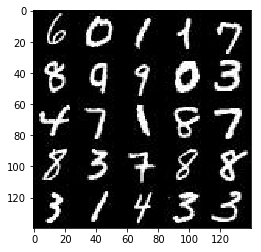

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

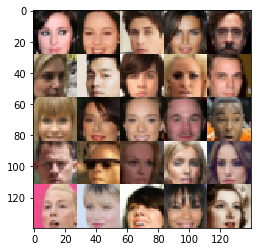

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/reza/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='var_learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x out_channel_dim
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64 now
        
        x2 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4 x 4 x 256 now
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2 x 2 x 512 now

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
        
    training = is_train
    output_dim = out_channel_dim
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 28 x 28
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=training)
        x4 = tf.maximum(alpha * x4, x4)
        # 28 x 28
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, output_dim, 5, strides=1, padding='same')
        # 28 x 28 x out_channel_dim now        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    out_channel_dim = data_shape[3]

    # data_image_mode used for setting image_channels size
    if (data_image_mode == "RGB"):
        image_channels = 3
    else: # (data_image_mode == "L"):
        image_channels = 1
    
    input_real, input_z, input_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    saver = tf.train.Saver()

    #samples, losses = [], []
    
    # ???
    z_size = z_dim
    print_every = 10 # copied from master
    show_every = 100 # recommended value from text above
    n_images = 16 # number of images to display for generator output
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2 # images are between -0.5 and 0.5
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    input_learning_rate: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    input_learning_rate: learning_rate
                })
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3695... Generator Loss: 3.7963
Epoch 1/2... Discriminator Loss: 0.3647... Generator Loss: 4.9885
Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 5.8194
Epoch 1/2... Discriminator Loss: 0.3603... Generator Loss: 5.1917
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 6.3246
Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 5.7550
Epoch 1/2... Discriminator Loss: 0.3569... Generator Loss: 4.8156
Epoch 1/2... Discriminator Loss: 0.3384... Generator Loss: 5.6214
Epoch 1/2... Discriminator Loss: 0.3334... Generator Loss: 6.6128
Epoch 1/2... Discriminator Loss: 0.3564... Generator Loss: 4.3666


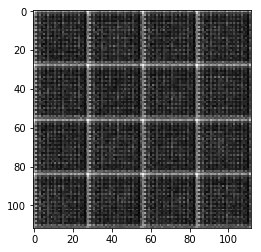

Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 4.7552
Epoch 1/2... Discriminator Loss: 4.4551... Generator Loss: 0.1254
Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 0.6066
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 2.3974
Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 2.8836
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 1.7429
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.8676
Epoch 1/2... Discriminator Loss: 1.1555... Generator Loss: 0.7185


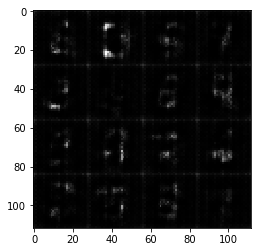

Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 2.0519
Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 1.5353
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.4860
Epoch 1/2... Discriminator Loss: 0.7828... Generator Loss: 1.3223
Epoch 1/2... Discriminator Loss: 1.3423... Generator Loss: 0.5475
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 1.3551
Epoch 1/2... Discriminator Loss: 0.7001... Generator Loss: 1.5130
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 1.2012
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 1.0866


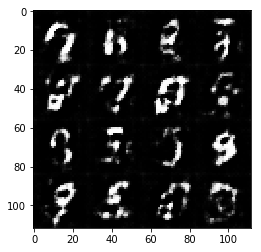

Epoch 1/2... Discriminator Loss: 0.7158... Generator Loss: 1.5508
Epoch 1/2... Discriminator Loss: 0.7542... Generator Loss: 1.5916
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.2854
Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 1.8156
Epoch 1/2... Discriminator Loss: 0.8029... Generator Loss: 1.2191
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 1.9396
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 2.1122
Epoch 1/2... Discriminator Loss: 0.9277... Generator Loss: 0.9392
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 2.3335
Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 1.7631


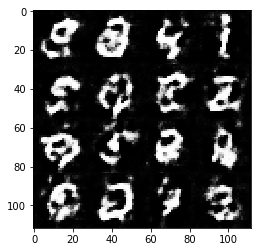

Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 2.4632
Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 3.1416
Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 1.9463
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 1.4397
Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 1.3529
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 1.0677
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 2.1341
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 1.6442
Epoch 1/2... Discriminator Loss: 0.7682... Generator Loss: 1.5717


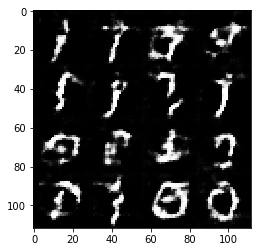

Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 2.2167
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 1.1622
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 2.0046
Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.6339
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 1.6424
Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 1.7158
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 1.8134
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 1.6593
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.9831


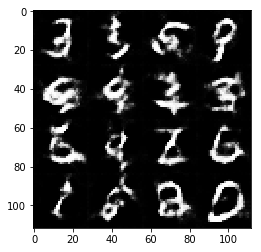

Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 1.5870
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 2.0113
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 2.3415
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.2807
Epoch 1/2... Discriminator Loss: 1.0006... Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.5574
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 1.6805
Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 1.1122
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.7947


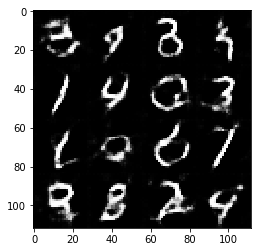

Epoch 1/2... Discriminator Loss: 1.5975... Generator Loss: 3.3509
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 1.3703
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.8263
Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 1.5835
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 2.5338
Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.2985
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 0.8998... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.7499
Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 1.4722


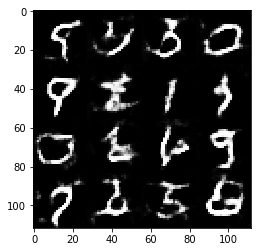

Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.4735
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.7839
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.4616
Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 1.2818
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 2.0888
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 0.7524... Generator Loss: 1.5829


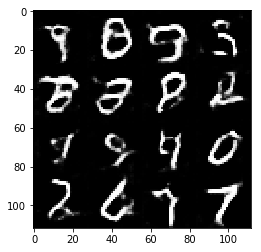

Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 0.8958... Generator Loss: 1.1246
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.3881
Epoch 2/2... Discriminator Loss: 1.0191... Generator Loss: 2.5242
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 2.0222
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.0977
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 0.9988
Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 0.9588


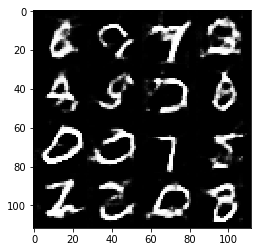

Epoch 2/2... Discriminator Loss: 0.8325... Generator Loss: 1.2329
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.2275
Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 1.1180
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.1610
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 1.9757
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.0649


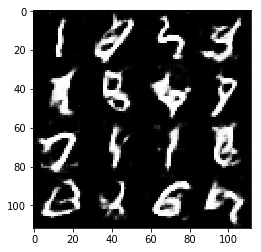

Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.3719
Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 1.0647
Epoch 2/2... Discriminator Loss: 0.8694... Generator Loss: 1.7031
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 2.3711
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.7263
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 2.1365
Epoch 2/2... Discriminator Loss: 0.7524... Generator Loss: 1.4780
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.7735


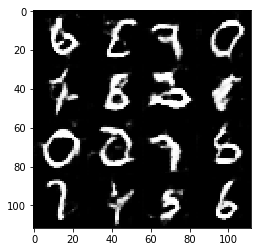

Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 2.1280
Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 1.5047
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 1.1957
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 1.1765
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 1.6378
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.9532
Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.5159
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 1.2997
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.5845


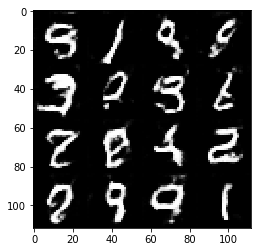

Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 1.2009
Epoch 2/2... Discriminator Loss: 1.5447... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.7488
Epoch 2/2... Discriminator Loss: 0.8292... Generator Loss: 1.2224
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 2.2891
Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 1.7161
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 0.9744
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 2.3205
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 0.9960
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.8443


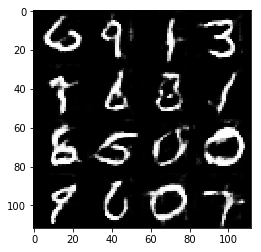

Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 2.7129
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.6616
Epoch 2/2... Discriminator Loss: 0.8579... Generator Loss: 1.2362
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 1.1922
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 2.0392
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 1.5819
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.8710


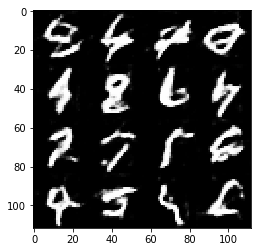

Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.1470
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 1.3973
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 2.0121
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 1.3233
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 2.1658
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 0.9984
Epoch 2/2... Discriminator Loss: 0.7896... Generator Loss: 1.4910
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.1244
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.3789


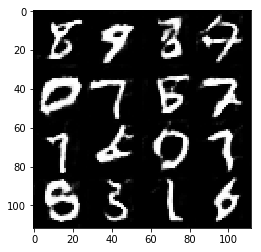

Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 0.9266
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.4461
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 2.3019
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.5093
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.3853
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 2.8896
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.1385


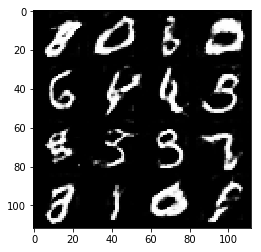

Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.4599
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.7397
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.4186
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 2.1861
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.3036
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 1.0275
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 1.0610
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.4230


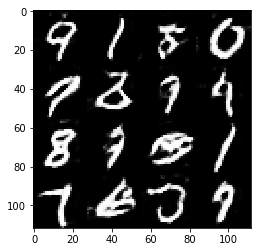

Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.1701
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.4542


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 2.6461
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 3.2842
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 3.2662
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 2.5553
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 3.9900
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 2.6415
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 3.0435
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 3.8668
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 4.7504
Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 2.4987


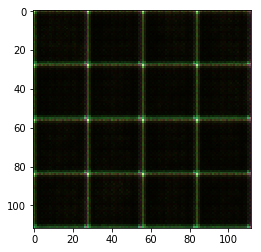

Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 3.2194
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.8174
Epoch 1/1... Discriminator Loss: 0.4392... Generator Loss: 3.7020
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 2.5654
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 3.7068
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 1.9702
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.4671
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 3.7767
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 4.1211


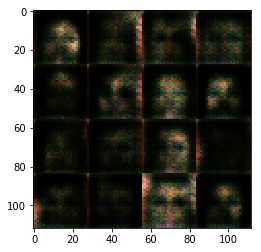

Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 2.9754
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.7965... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.7179
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 2.1563
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 2.1983
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.7859


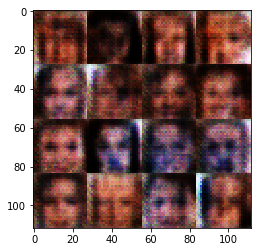

Epoch 1/1... Discriminator Loss: 0.6054... Generator Loss: 1.7782
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 1.7825
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 2.2590
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 1.9730
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.0309
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.6341
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.3105
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.3412


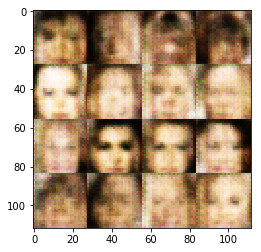

Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.5698
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 2.8026
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.7566
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.1308
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 3.0478
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.5843
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 3.9356
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 2.1121


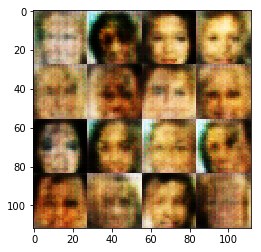

Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 2.3661
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 2.2220
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 3.0050
Epoch 1/1... Discriminator Loss: 2.0974... Generator Loss: 6.0647
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 2.4326
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 2.7536
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 2.1942
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.4833


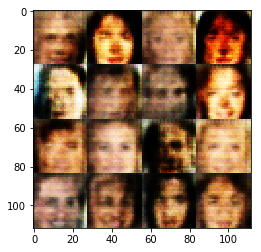

Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.3162
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 2.6955
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.6843
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 2.7332
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 4.7674
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 2.6216
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.1041


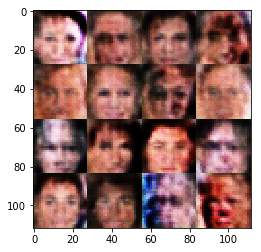

Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.5673
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 2.0849
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 2.5535
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.8069
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 2.2872
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 2.4799
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 1.8062


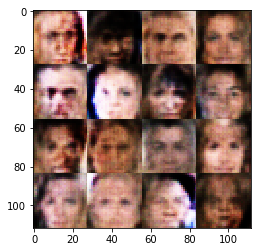

Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 3.5809
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 2.3528
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 3.1822
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 3.9573
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 2.3444
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 2.7873
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 2.1443
Epoch 1/1... Discriminator Loss: 2.7581... Generator Loss: 0.1434


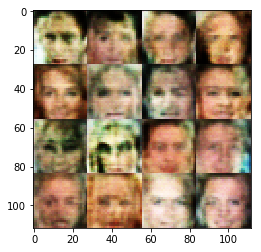

Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 1.9799
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 3.2700
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 2.2358
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 2.8839
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.4793


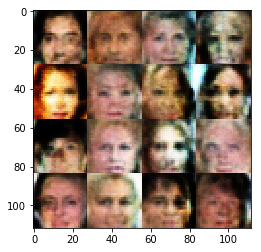

Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 4.6536
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 2.9522
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 2.5571
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 3.3772
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.6032
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 3.7738
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 3.4986
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 2.6828
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 2.5862


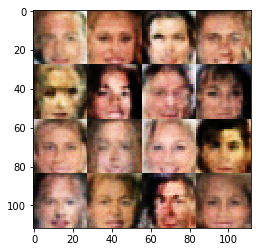

Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 3.7697
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.7485
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 2.0211
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 2.8072
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 2.2275
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 2.6318
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6727


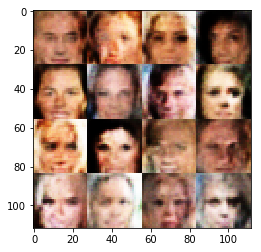

Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.9470
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.2211
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 2.0309
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 2.3960
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 2.0733


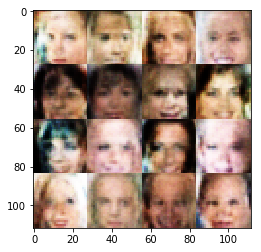

Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 1.8648
Epoch 1/1... Discriminator Loss: 2.0282... Generator Loss: 0.3959
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 0.7357... Generator Loss: 3.6246
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.7314
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.6743
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 2.1853
Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 2.6651
Epoch 1/1... Discriminator Loss: 2.2378... Generator Loss: 0.3479


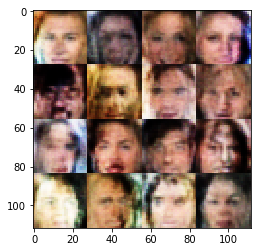

Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.4327
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 1.8703
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 1.7771
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.0208


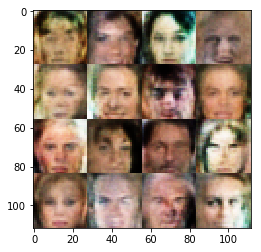

Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 2.1192
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 2.2134
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 2.0240
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.6286
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.8840
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 2.1763
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.8998
Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 2.2881


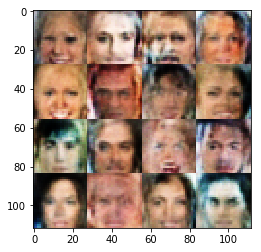

Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 2.1184
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.6480
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.7763
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 1.9477
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 1.5926
Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 1.5326
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 2.1200


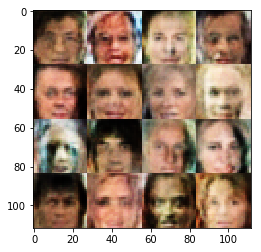

Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 3.4853
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 2.7776
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 2.6715
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.8812
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.9157
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 2.8349
Epoch 1/1... Discriminator Loss: 2.4381... Generator Loss: 4.6049
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.4866


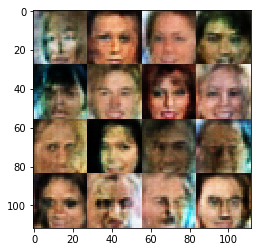

Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.4273
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 1.7320
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.7305
Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 2.8977
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 3.2684


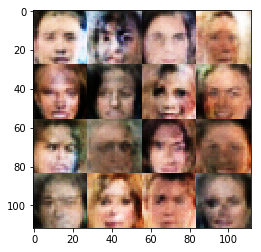

Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 3.4928
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.8114
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 2.3550
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.8370
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 3.0358
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 2.5415


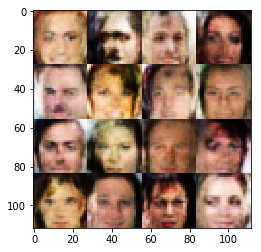

Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 2.4150
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 2.3478
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 2.2715
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 1.9186
Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 2.2997
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.8753
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.6916


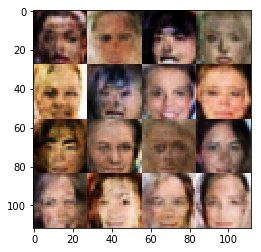

Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.2272
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 3.0910
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 2.1921
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.8779
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.7060
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.8137


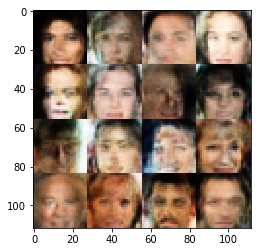

Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 2.2601
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 2.1687
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 2.5028
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 2.6030
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.8519
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 2.0871
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 1.2780


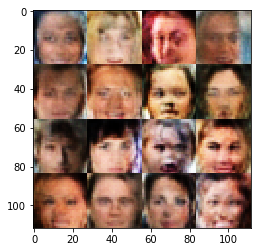

Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 2.9252
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 1.5025
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.5270
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 2.1039
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 2.6892
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 3.8660
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.6393
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 1.7661


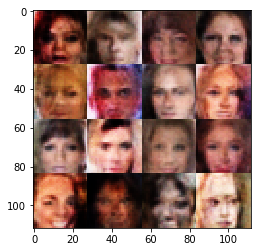

Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 2.2772
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 2.3542
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 1.9236
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 3.4562
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 2.2847
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.5252
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.8497


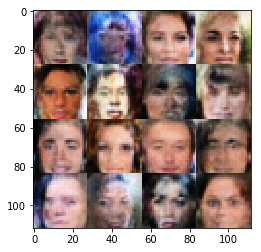

Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 2.2403
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.5742
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 2.6971
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.8800
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 2.1384
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.8511
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.7321


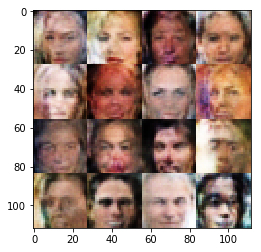

Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 2.9509
Epoch 1/1... Discriminator Loss: 0.5384... Generator Loss: 3.3659
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.5538
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 2.6885
Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 2.1867
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.0334


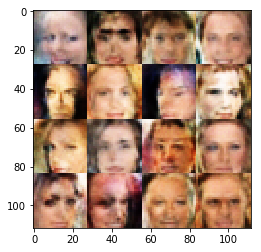

Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 2.2078
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.1960
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 2.0373
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 3.7160
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.4174
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.5365
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.8924
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 1.2150


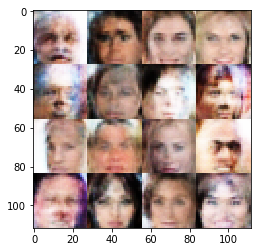

Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 2.4490
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 2.1453
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 2.2374
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 2.0763
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 2.6368
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 2.8565
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 2.3080


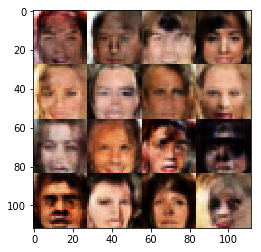

Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.6427
Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 1.7522
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 2.3179
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 2.2397
Epoch 1/1... Discriminator Loss: 2.6091... Generator Loss: 4.5172
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.4925
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.5036
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.5759


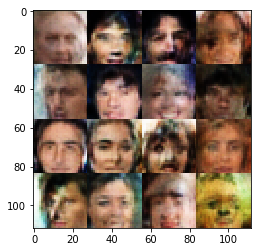

Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 2.0659
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.9802
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 2.3140
Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 1.8919
Epoch 1/1... Discriminator Loss: 3.2723... Generator Loss: 6.0592
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 1.6390


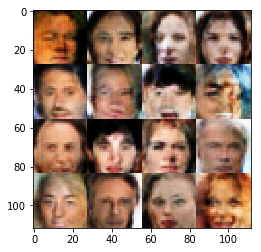

Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 2.9136
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 3.4489
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.7091
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 2.1147
Epoch 1/1... Discriminator Loss: 1.6798... Generator Loss: 0.4388


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.